# Sample Philips 3D RF Analysis

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Select Image & Phantom and Parse

In [2]:
from pyquantus.parse.philips3dRf import getVolume

In [3]:
rfPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Philips 3D RF/SHC-P004-V03-RF1_20241015_155205.rf')

In [4]:
imgData, imgInfo = getVolume(rfPath)

Reading SIP scan conversion VDB Params...
Finished reading SIP scan converstion VDB params...
Opening: /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Philips 3D RF/SHC-P004-V03-RF1_20241015_155205.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 6
	Header Size: 880 bytes

Elapsed time is 0:01:11.475692 seconds.
Parsing header info ...
Elapsed time is 0:01:11.768101 seconds.
Parsing RF data ...
Elapsed time is 0:01:28.796373 seconds.
Organizing based on data type ...
	PostXBR
		Capture_ML:	16x

		Echo_ML:	4x

		CRE:	4

Elapsed time is 0:01:35.318694 seconds.
Done


# VOI Selection

In [5]:
# Define cube for analysis
startIxZ = 100; endIxZ = 150
startIxX = 90; endIxX = 150
startIxY = 130; endIxY = 230
voiMask = np.zeros_like(imgData.scBmode)
voiMask[startIxX:endIxX, startIxY:endIxY, startIxZ:endIxZ] = 1
voiMask = voiMask.astype(bool)

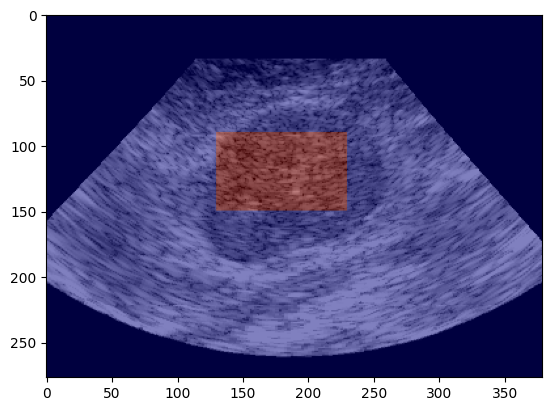

In [6]:
plt.imshow(imgData.scBmode[:, :, 100], cmap='gray')
plt.imshow(voiMask[:, :, 100], cmap='jet', alpha=0.5)

In [7]:
imgData.bMode.shape

(486, 168, 22)

# Map to original

In [11]:
def map1dTo3d(coord, xDim, yDim, zDim):
    x = coord // (zDim * yDim)
    coord -= x * (zDim * yDim)
    y = coord // zDim
    z = coord - (y * zDim)
    
    return x, y, z

def splineToPreSc(preScBmode: np.ndarray, coordMap: np.ndarray, voiMask: np.ndarray) -> np.ndarray:
    maskedCoords3d = np.transpose(np.where(voiMask))
    originalCoords3d = []
    for coord in maskedCoords3d:
        originalCoords3d.append(map1dTo3d(coordMap[coord[0], coord[1], coord[2]], preScBmode.shape[0], preScBmode.shape[1], preScBmode.shape[2]))
    return np.array(originalCoords3d)

In [12]:
originalCoords3d = splineToPreSc(imgData.bMode, imgData.coordMap3d, voiMask)

In [13]:
originalCoords3d

array([[185,  38,   4],
       [185,  38,   5],
       [184,  38,   5],
       ...,
       [268, 109,  11],
       [268, 109,  12],
       [269, 109,  12]], shape=(300000, 3))

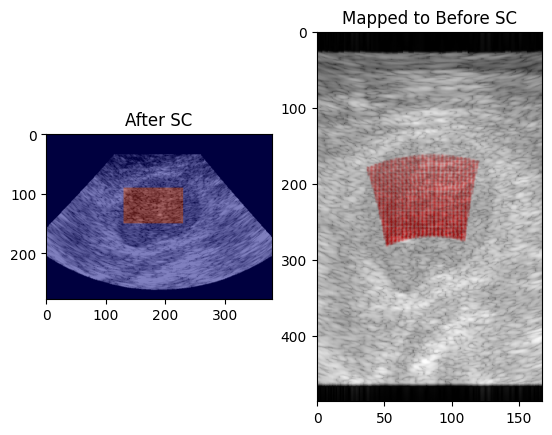

In [55]:
plane = 7
curPlaneCoords = []
for coord in originalCoords3d:
    if coord[2] == plane:
        curPlaneCoords.append((coord[0], coord[1]))
curPlaneCoords = np.array(curPlaneCoords)
        
fig, axs = plt.subplots(1, 2)
axs[0].set_title('After SC')
axs[0].imshow(imgData.scBmode[:, :, 100], cmap='gray', aspect='auto')
axs[0].imshow(voiMask[:, :, 100], cmap='jet', alpha=0.5)
axs[1].set_title('Mapped to Before SC')
axs[1].imshow(imgData.bMode[:, :, plane], cmap='gray', aspect='auto')
axs[1].scatter(curPlaneCoords[:, 1], curPlaneCoords[:, 0], color=(0.9, 0.1, 0.1, 0.01), s=1)
plt.show()

# Analysis Config

In [37]:
from pyquantus.utc import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [2000000, 8000000] # [min, max] (Hz)
config.analysisFreqBand = [3000000, 7000000] # [lower, upper] (Hz)
config.samplingFrequency = 20000000 # Hz
config.axWinSize = 0.71 # axial length per window (mm)
config.latWinSize = 0.71 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 9000000 # Hz

# UTC Analysis